# Análisis de Sentimientos en Tweets de Aerolíneas

En el presente Notebook se creará un modelo para el análisis de sentimientos utilizando Tweets de aerolíneas. La información es sumistrada por [Kaggle](https://www.kaggle.com/welkin10/airline-sentiment).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from metrics import plot_confusion_matrix 
import numpy as np
import nltk
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import tensorflow as tf

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jcobapuerto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Cargue de Información

A continuación se cargará la base de datos de Tweets para el análisis de sentimientos. Se cuenta con 14640 tweets de comentarios a aerolíneas. De estos comentarios, el 62% corresponde a comentarios negativos, 21% son neutrales y apenas el 16% son positivos. Estos comentarios son realizados a seis aerolíneas de Estados Unidos de América, de las cuales 5 concentran el 96.5% de los tweets.

In [3]:
df = pd.read_csv('data/Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.airline_sentiment.value_counts()/len(df)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [6]:
df.airline.value_counts()/len(df)

United            0.261066
US Airways        0.198975
American          0.188456
Southwest         0.165301
Delta             0.151776
Virgin America    0.034426
Name: airline, dtype: float64

In [7]:
by_airline = pd.DataFrame(df.groupby('airline')['airline_sentiment'].value_counts())

Se observa que los sentimientos negativos predominan en la mayoría de las aerolíneas, pero en algunas la concentración es menos dispareja.

In [8]:
by_airline/by_airline.groupby('airline').sum()

airline_sentiment
airline        airline_sentiment                   
American       negative                    0.710402
               neutral                     0.167814
               positive                    0.121783
Delta          negative                    0.429793
               neutral                     0.325383
               positive                    0.244824
Southwest      negative                    0.490083
               neutral                     0.274380
               positive                    0.235537
US Airways     negative                    0.776862
               neutral                     0.130793
               positive                    0.092345
United         negative                    0.688906
               neutral                     0.182365
               positive                    0.128728
Virgin America negative                    0.359127
               neutral                     0.339286
               positive                    0.301587

Se omiten los tweets con sentimiento neutral.

In [9]:
df = df[df.airline_sentiment != 'neutral']

In [10]:
df['airline_sentiment'] = 1*(df['airline_sentiment'] == 'positive')

## 2. Procesamiento de Texto

En esta sección se discuten las transformaciones que se realizarán al texto para poder extraer características. A continuación se realizarán los siguientes procesamientos:
1. Eliminar menciones (e.g. @USAirways, @BohnJai) que no aportan al sentimiento
2. Convertir el texto en minúsculas
3. Eliminar caracteres especiales
4. Eliminación de stopwords

In [11]:
df.text.head()

1    @VirginAmerica plus you've added commercials t...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

### 2.1. Eliminación de Menciones

Para esta tarea se utilizarán expresiones regulares para eliminar todas las palabras que sigan después de un signo de @. Con la siguiente expresión regular **@[A-Za-z0-9_]** se están seleccionando todos los caracteres que contengan letras, números y guiónes bajos después de un @. 

In [12]:
df['text'] = df.text.str.replace("'", ' ')
df['text'] = df.text.str.replace(r"@[A-Za-z0-9_]+", '')

<ipython-input-12-6565c048f666>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df.text.str.replace(r"@[A-Za-z0-9_]+", '')


In [13]:
df.text.head()

1     plus you ve added commercials to the experien...
3     it s really aggressive to blast obnoxious "en...
4             and it s a really big bad thing about it
5     seriously would pay $30 a flight for seats th...
6     yes, nearly every time I fly VX this “ear wor...
Name: text, dtype: object

### 2.2. Eliminación de Caracteres Especiales y Minúsculas

In [14]:
df['text'] = df.text.str.lower()

In [15]:
df['text'] = df.text.str.replace(r"[^a-z\d\s:]+", '')

<ipython-input-15-0cd7b1f2fbc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df.text.str.replace(r"[^a-z\d\s:]+", '')


In [16]:
df['text'] = df.text.str.lstrip()
df['text'] = df.text.str.replace(' +', ' ')


<ipython-input-16-f1f58978fa96>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df.text.str.replace(' +', ' ')


In [17]:
df.text.head()

1    plus you ve added commercials to the experienc...
3    it s really aggressive to blast obnoxious ente...
4             and it s a really big bad thing about it
5    seriously would pay 30 a flight for seats that...
6    yes nearly every time i fly vx this ear worm w...
Name: text, dtype: object

### 2.3. Eliminación de StopWords

In [18]:
stp_words = stopwords.words('english')

In [19]:
df['text'] = df.text.str.split(' ')

In [20]:
df.text.head()

1    [plus, you, ve, added, commercials, to, the, e...
3    [it, s, really, aggressive, to, blast, obnoxio...
4    [and, it, s, a, really, big, bad, thing, about...
5    [seriously, would, pay, 30, a, flight, for, se...
6    [yes, nearly, every, time, i, fly, vx, this, e...
Name: text, dtype: object

In [21]:
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stp_words])
df['text'] = df['text'].apply(lambda x: [item for item in x if len(item) > 0])

In [22]:
df.text.head()

1        [plus, added, commercials, experience, tacky]
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
5    [seriously, would, pay, 30, flight, seats, pla...
6    [yes, nearly, every, time, fly, vx, ear, worm,...
Name: text, dtype: object

### 2.4 Selección de Muestra
Se puede apreciar que después de la limpieza hay 237 registros que quedan con menos de 2 palabras, por lo que son eliminados.

In [23]:
df['n_words'] = df['text'].str.len()

In [24]:
df['n_words'].value_counts()

11    1220
12    1199
10    1106
9     1083
13     950
8      847
14     745
7      717
6      692
5      540
4      489
15     458
3      391
2      313
16     271
1      228
17     150
18      71
19      37
20      16
0        9
21       7
22       1
23       1
Name: n_words, dtype: int64

In [25]:
df[df.n_words == 1].text

14           [thanks]
18           [flying]
163         [website]
192            [suck]
193          [thanks]
             ...     
13814         [ticks]
14132         [close]
14300    [delayedwow]
14450        [expect]
14630        [thanks]
Name: text, Length: 228, dtype: object

In [26]:
df["text"]= df["text"].str.join(" ")

## 3. Train-Test Split

En esta sección se realizará una separación de los datos en tres conjuntos: entrenamiento, validación y prueba. Los modelos se van a entrenar utilizando el conjunto de datos de entrenamiento y se compararán entre ellos utilizando los datos de validación. Finalmente, el mejor modelo se probará contra Test para determinar el desempeño en un ambiente productivo. 

Como el objetivo es poder clasificar los sentimientos asociados a Tweets, se utilizará únicamente la información del texto de sentimiento. Se omite la información de la aerolínea (para evitar los posibles sesgos de aerolíneas con mayor concentración de comentarios negativos). 

Al ser la variable dependiente una categoría, la repartición se hace de manera estratificada, con el fin de mantener las proporciones generales del dataset.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [28]:
print(f'Tamaño de Información:\nEntrenamiento: {round(len(X_train)/len(df)*100, 1)}%.\n   Validación: {round(len(X_val)/len(df)*100, 1)}%. \n       Prueba: {round(len(X_test)/len(df)*100, 1)}%.')

Tamaño de Información:
Entrenamiento: 64.0%.
   Validación: 16.0%. 
       Prueba: 20.0%.


In [29]:
X_train.head()

3954     miles going restructured help silver status br...
10815    fight delayed 3 hrs mco stuck philly standby t...
3337         kind cool run boss man sfo http:tcobm9o2k5x5j
1028     musicians real dirty lax never blocked getting...
8091                               flights delayed :gtgtgt
Name: text, dtype: object

In [30]:
y_train.head()

3954     0
10815    0
3337     1
1028     0
8091     0
Name: airline_sentiment, dtype: int64

## 4. Construcción de Features

En este paso se construirán las características para el entrenamiento del modelo. Se construirá un TF-IDF con los textos seleccionados para el entrenamiento, y se apilcará para Validación y Prueba.

In [31]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [32]:
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [33]:
X_train.shape

(7385, 10049)

## 5. Entrenamiento de Modelos

En esta sección se realiza el entrenamiento de los diferentes modelos sugeridos, a saber: 
1. Regresión Logística
2. Naïve Bayes
3. Support Vector Machines
4. Redes Neuronales

Estos modelos se entrenarán independientemente utilizando el conjunto de datos de entrenamiento, y se calcularán métricas de desempeño en el dataset de valdiación. Se analizarán las sigiuentes métricas: 
1. **Accuracy:** Para determinar la precisión global del modelo
2. **F1:** Para determinar la capacidad de discriminar entre las dos clases
3. **Matriz de Confusión:** Para visualziar el desempeño y los errores de clasificación


In [88]:
def get_model_metrics(model, X, y):

    y_pred = model.predict(X)
    
    plot_confusion_matrix(y, y_pred, np.unique(df.airline_sentiment.values), normalize=True)
    plt.show()
    
    accuracy = round(accuracy_score(y, y_pred)*100, 1)
    f1 = round(f1_score(y_pred, y, average = 'macro')*100, 1)
    
    print(f'El modelo presenta un accuracy de {accuracy}% y un F1 de {f1}%')

In [89]:
def get_model_metrics_tf(model, X, y):

    y_pred = model.predict_classes(X)
    
    plot_confusion_matrix(y, y_pred, np.unique(df.airline_sentiment.values), normalize=True)
    plt.show()
    
    accuracy = round(accuracy_score(y, y_pred)*100, 1)
    f1 = round(f1_score(y_pred, y, average = 'macro')*100, 1)
    
    print(f'El modelo presenta un accuracy de {accuracy}% y un F1 de {f1}%')

### 5.1 Regresión Logística

In [90]:
logit = LogisticRegression(random_state=0).fit(X_train, y_train)

In [91]:
y_pred = logit.predict(X_val)

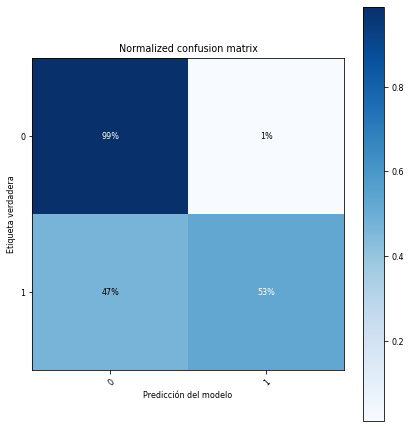

El modelo presenta un accuracy de 89.6% y un F1 de 80.5%


In [92]:
get_model_metrics(logit, X_val, y_val)

### 5.2 Naïve Bayes

In [93]:
naive_bayes = GaussianNB().fit(X_train.toarray(), y_train)

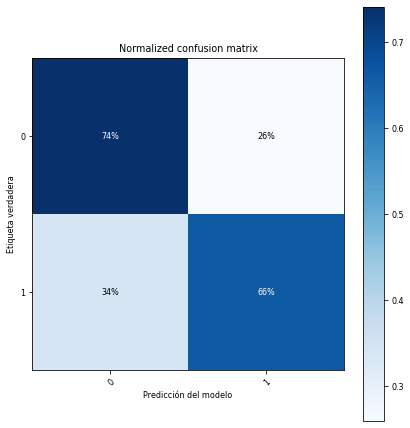

El modelo presenta un accuracy de 72.4% y un F1 de 65.2%


In [94]:
get_model_metrics(naive_bayes, X_val.toarray(), y_val)

### 5.3 Support Vector Machines

In [95]:
SVM = svm.SVC().fit(X_train, y_train)

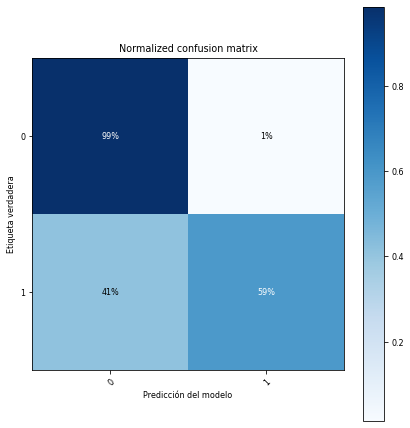

El modelo presenta un accuracy de 90.5% y un F1 de 82.9%


In [96]:
get_model_metrics(SVM, X_val, y_val)

#### 5.4 Redes Neuronales

In [49]:
X_train_tf, X_test_tf, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.2, random_state=1)
X_train_tf, X_val_tf, y_train, y_val = train_test_split(X_train_tf, y_train, test_size=0.2, random_state=1)

In [50]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)


In [52]:
encoder.adapt(X_train_tf.values)

In [59]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [60]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])



In [61]:
history = model.fit(X_train_tf, y_train, validation_data=(X_val_tf, y_val), epochs=100, callbacks = [earlystopping_callback], verbose = 1)

Epoch 1/100
231/231 [==============================] - 11s 20ms/step - loss: 0.6324 - accuracy: 0.7949 - val_loss: 0.4374 - val_accuracy: 0.7975
Epoch 2/100
231/231 [==============================] - 3s 13ms/step - loss: 0.4394 - accuracy: 0.7858 - val_loss: 0.3357 - val_accuracy: 0.7975
Epoch 3/100
231/231 [==============================] - 3s 14ms/step - loss: 0.3097 - accuracy: 0.8166 - val_loss: 0.2591 - val_accuracy: 0.8912
Epoch 4/100
231/231 [==============================] - 3s 13ms/step - loss: 0.2289 - accuracy: 0.9118 - val_loss: 0.2421 - val_accuracy: 0.9063
Epoch 5/100
231/231 [==============================] - 3s 12ms/step - loss: 0.2003 - accuracy: 0.9242 - val_loss: 0.2351 - val_accuracy: 0.9096
Epoch 6/100
231/231 [==============================] - 3s 11ms/step - loss: 0.1770 - accuracy: 0.9343 - val_loss: 0.2352 - val_accuracy: 0.9096
Epoch 7/100
231/231 [==============================] - 3s 12ms/step - loss: 0.1727 - accuracy: 0.9341 - val_loss: 0.2386 - val_accuracy

In [62]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot:>

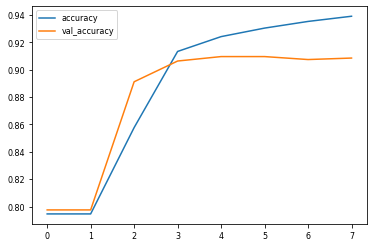

In [63]:
metrics[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

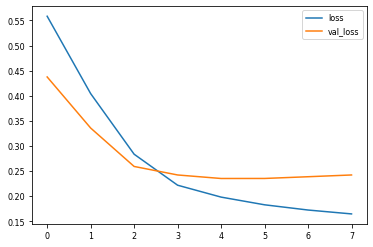

In [64]:
metrics[['loss', 'val_loss']].plot()

/Users/jcobapuerto/Library/Python/3.8/lib/python/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


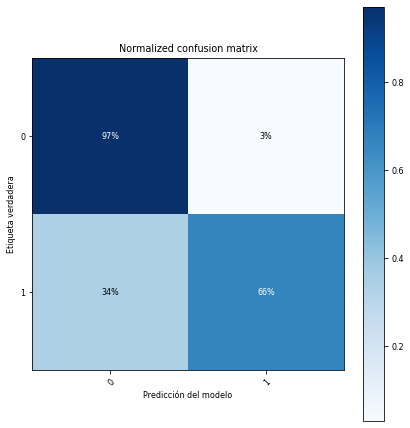

El modelo presenta un accuracy de 90.9% y un F1 de 84.5%


In [97]:
get_model_metrics_tf(model, X_val_tf, y_val.values)

## 6. Selección del Mejor Modelo
Basado en las métricas de validación, se ha determinado que el mejor modelo para clasificación de sentimientos de tweets de aerolíneas, es el modelo de red neuronal. Este modelo tiene un accuracy de 90.9% y un F1 de 84.5

Este modelo es muy bueno determinando cuándo un comentario es negativo, pues los detecta con un accuracy de 97%. Sin embargo, su capacidad para detectar sentimientos positivos no es tan buena, y suele confundirse. Este problema puede ser resuelto probando otras configuraciones de hiperparámetros o incluso ampliando el conjunto de datos de entrenamiento.

In [101]:
y_pred = model.predict_classes(X_test_tf)

/Users/jcobapuerto/Library/Python/3.8/lib/python/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [102]:
y_pred.shape

(2309, 1)

In [103]:
y_pred = np.squeeze(y_pred, -1)

In [104]:
y_pred.shape

(2309,)

In [105]:
y_test.shape

(2309,)

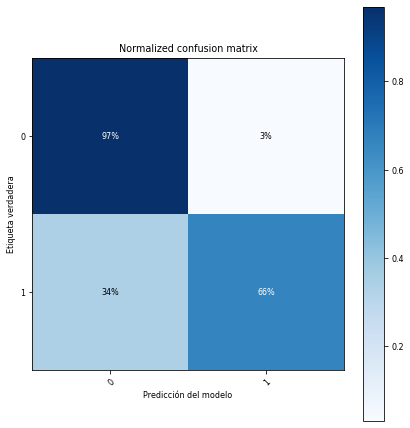

El modelo presenta un accuracy de 90.6% y un F1 de 84.3%


In [107]:
plot_confusion_matrix(y_test, y_pred, np.unique(df.airline_sentiment.values), normalize=True)
plt.show()

accuracy = round(accuracy_score(y_test, y_pred)*100, 1)
f1 = round(f1_score(y_pred, y_test, average = 'macro')*100, 1)

print(f'El modelo presenta un accuracy de {accuracy}% y un F1 de {f1}%')

El desempeño del modelo es consistente con lo visto en validación. Se espera que sea muy bueno detectando los comentarios negativos, y tenga una confusión del 33% en comentarios positivos. 